# Exploration 9: Diagnose Pneumonia - Chest X-Ray

---

#### Model
* CNN

#### Datasets
* Chest X-Rays from Kaggle

#### Goals

1. Plot graphs
2. Ablation study 
3. Accuracy above 85%
---

## Importing Dependencies

laying the foundation to build my model on

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("All imported!")

All imported!


In [2]:
# to load the data faster
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY image size
IMAGE_SIZE = [180, 180]

# data path
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# change these later
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


---

## Loading data

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


need adjustment b/c there are too little val data

In [4]:
# add train and validation data into filenames
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# divide them
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


the number of Pneumonia images are three times bigger than the Normal images

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # if Pneumonia then True, if Normal then False

In [10]:
# transform images
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # to uint8 tensor
    img = tf.image.convert_image_dtype(img, tf.float32) # to float32 type
    img = tf.image.resize(img, IMAGE_SIZE) # changing size
    return img

# return image and label
def process_path(file_path):
    label = get_label(file_path) # get label
    img = tf.io.read_file(file_path) # read image
    img = decode_img(img) # transform
    return img, label

Dividing into train and validation dataset

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Checking

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


Test dataset

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

Data visualization

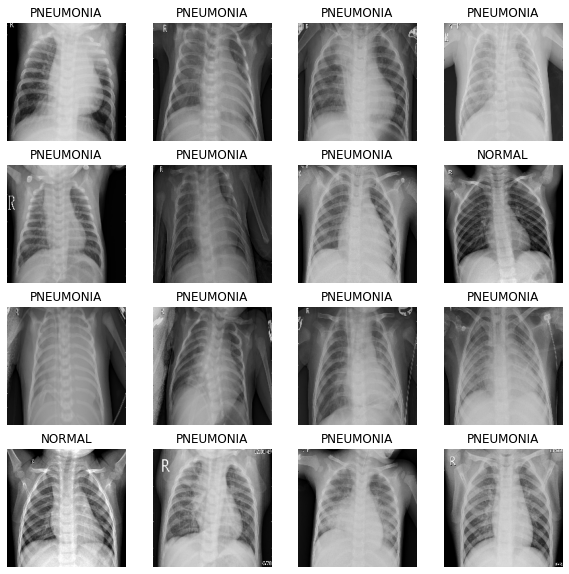

In [15]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

## Model

### Using both Batch Normalization and Dropout
#### Covolution block

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

#### Dense block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

#### building model

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

## Imbalanced data

### Weight balancing

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


## Compile and Fit

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

In [31]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 56s 190ms/step - loss: 0.1164 - accuracy: 0.9550 - precision: 0.9876 - recall: 0.9514 - val_loss: 0.0695 - val_accuracy: 0.9740 - val_precision: 0.9868 - val_recall: 0.9777
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1298 - accuracy: 0.9502 - precision: 0.9869 - recall: 0.9456 - val_loss: 0.0491 - val_accuracy: 0.9837 - val_precision: 0.9895 - val_recall: 0.9882s: 0.1326 - accuracy: 0.9494 - precision: 0.
Epoch 3/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1282 - accuracy: 0.9531 - precision: 0.9869 - recall: 0.9494 - val_loss: 0.0992 - val_accuracy: 0.9615 - val_precision: 0.9945 - val_recall: 0.9529
Epoch 4/25
261/261 [==============================] - 49s 188ms/step - loss: 0.1139 - accuracy: 0.9538 - precision: 0.9870 - recall: 0.9505 - val_loss: 0.2147 - val_accuracy: 0.9212 - val_precision: 1.0000 - val_recall: 0.8927
Epoch 00004: early stopping


### plot graphs

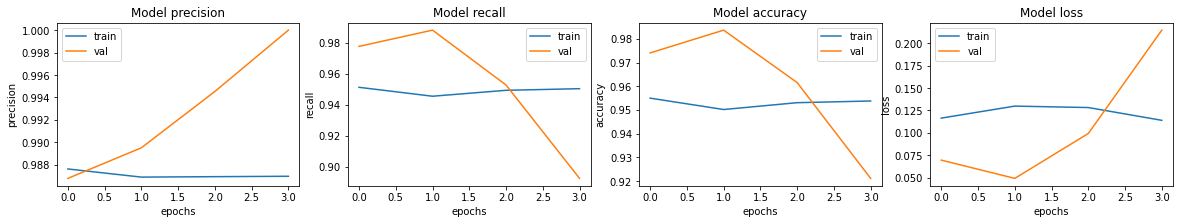

In [32]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

## Evaluate

In [33]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 110ms/step - loss: 0.4196 - accuracy: 0.8670 - precision: 0.8681 - recall: 0.9282
Loss: 0.41960540413856506,
Accuracy: 0.8669871687889099,
Precision: 0.8681055307388306,
Recall: 0.928205132484436


## Fine-tuning

### Augmentation
#### Random flip (left&right)

having problem with the kernel, try later

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    ds = ds.map(
            augment,       
            num_parallel_calls=2
        )
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_aug = prepare_for_training_aug(train_ds)
val_ds_aug = prepare_for_training_aug(val_ds)

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch_aug, label_batch_aug = next(iter(train_ds_aug))
show_batch(image_batch_aug.numpy(), label_batch_aug.numpy())

### Batch Normalization and Dropout

#### Only BatchNormalization

In [34]:
def dense_block_B(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    
    ])
    
    return block

In [35]:
def build_model_B():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_B(512),
        dense_block_B(128),
        dense_block_B(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [41]:
with tf.device('/GPU:0'):
    model_B = build_model_B()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_B.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [42]:
with tf.device('/GPU:0'):
    history_B = model_B.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 58s 188ms/step - loss: 0.2579 - accuracy: 0.8875 - precision: 0.9711 - recall: 0.8748 - val_loss: 0.6611 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1691 - accuracy: 0.9409 - precision: 0.9837 - recall: 0.9359 - val_loss: 1.4721 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 184ms/step - loss: 0.1372 - accuracy: 0.9488 - precision: 0.9866 - recall: 0.9440 - val_loss: 0.3413 - val_accuracy: 0.8317 - val_precision: 0.8136 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 49s 187ms/step - loss: 0.1309 - accuracy: 0.9500 - precision: 0.9859 - recall: 0.9463 - val_loss: 0.1325 - val_accuracy: 0.9529 - val_precision: 0.9578 - val_recall: 0.9791
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1097 - accura

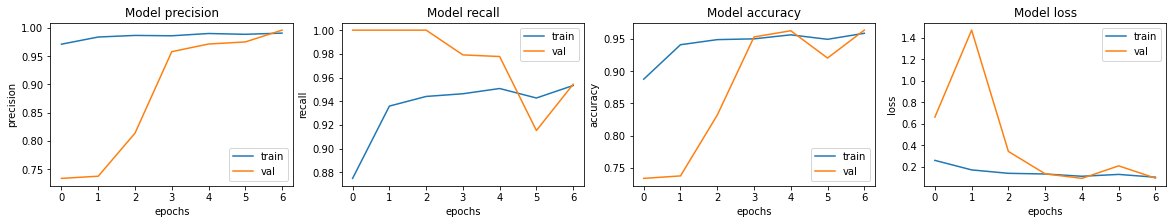

In [44]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_B.history[met])
    ax[i].plot(history_B.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [45]:
loss, accuracy, precision, recall = model_B.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 104ms/step - loss: 0.5468 - accuracy: 0.8446 - precision: 0.8151 - recall: 0.9718
Loss: 0.5468246936798096,
Accuracy: 0.8445512652397156,
Precision: 0.8150537610054016,
Recall: 0.971794843673706


#### Only Dropout

In [46]:
def dense_block_D(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [47]:
def build_model_D():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_D(512, 0.7),
        dense_block_D(128, 0.5),
        dense_block_D(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [48]:
with tf.device('/GPU:0'):
    model_D = build_model_D()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_D.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [49]:
with tf.device('/GPU:0'):
    history_D = model_D.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.3644 - accuracy: 0.8123 - precision: 0.9625 - recall: 0.7778 - val_loss: 0.7302 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 187ms/step - loss: 0.2183 - accuracy: 0.9205 - precision: 0.9779 - recall: 0.9137 - val_loss: 2.4868 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 48s 186ms/step - loss: 0.1471 - accuracy: 0.9420 - precision: 0.9828 - recall: 0.9385 - val_loss: 0.2615 - val_accuracy: 0.8750 - val_precision: 0.8552 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 48s 185ms/step - loss: 0.1227 - accuracy: 0.9528 - precision: 0.9863 - recall: 0.9498 - val_loss: 0.1002 - val_accuracy: 0.9644 - val_precision: 0.9619 - val_recall: 0.9908
Epoch 5/25
261/261 [==============================] - 49s 190ms/step - loss: 0.1039 - accura

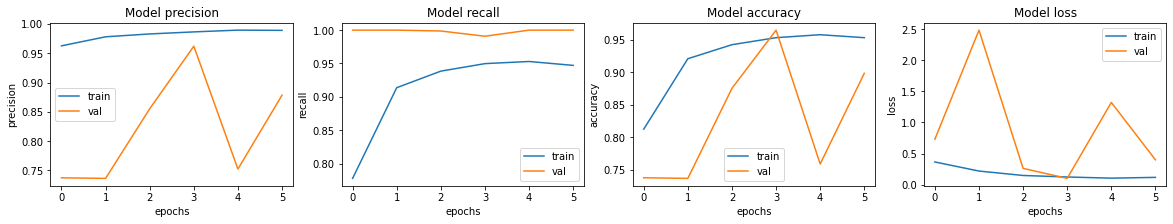

In [50]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_D.history[met])
    ax[i].plot(history_D.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [52]:
loss, accuracy, precision, recall = model_D.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 3.8933 - accuracy: 0.6651 - precision: 0.6511 - recall: 1.0000
Loss: 3.8933117389678955,
Accuracy: 0.6650640964508057,
Precision: 0.6510851383209229,
Recall: 1.0


#### None Batch Normalization and Dropout

In [53]:
def dense_block_no(units):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        
    ])
    
    return block

In [54]:
def build_model_no():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block_no(512),
        dense_block_no(128),
        dense_block_no(64),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [55]:
with tf.device('/GPU:0'):
    model_no = build_model_no()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_no.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [56]:
with tf.device('/GPU:0'):
    history_no = model_no.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight, callbacks=[es]
    )

Epoch 1/25
261/261 [==============================] - 58s 189ms/step - loss: 0.3003 - accuracy: 0.8709 - precision: 0.9639 - recall: 0.8588 - val_loss: 1.1124 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 49s 186ms/step - loss: 0.1820 - accuracy: 0.9145 - precision: 0.9835 - recall: 0.9001 - val_loss: 1.7911 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 49s 189ms/step - loss: 0.1483 - accuracy: 0.9392 - precision: 0.9850 - recall: 0.9324 - val_loss: 0.4003 - val_accuracy: 0.9077 - val_precision: 0.8893 - val_recall: 0.9987
Epoch 4/25
261/261 [==============================] - 50s 191ms/step - loss: 0.1241 - accuracy: 0.9495 - precision: 0.9865 - recall: 0.9449 - val_loss: 0.3316 - val_accuracy: 0.8529 - val_precision: 1.0000 - val_recall: 0.8000
Epoch 5/25
261/261 [==============================] - 49s 189ms/step - loss: 0.0948 - accura

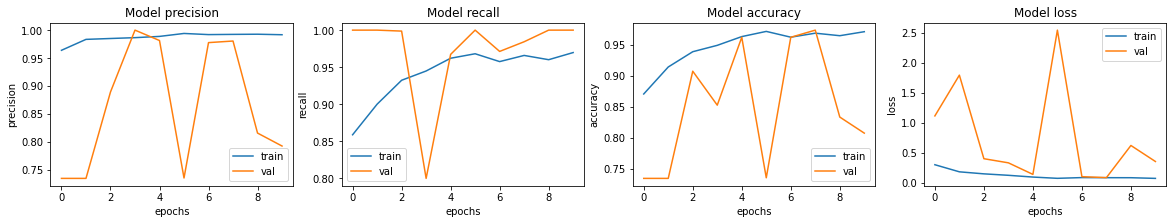

In [57]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history_no.history[met])
    ax[i].plot(history_no.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [59]:
loss, accuracy, precision, recall = model_no.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 106ms/step - loss: 1.6997 - accuracy: 0.6330 - precision: 0.6300 - recall: 1.0000
Loss: 1.6996796131134033,
Accuracy: 0.6330128312110901,
Precision: 0.6300484538078308,
Recall: 1.0


---

## Conclusion

Trying different Dense blocks were interesting.<br/>
Also wanted to try augmentation but weren't able to b/c of the unstable kernel<br/>

#### Comparision

| Model | Accuracy | Recall |
| :- | :-: | :-: |
| Batch Normalization & Dropout | 0.866 | 0.928 |
| Only Batch Normalization | 0.844 | 0.971 |
| Only Dropout | 0.665 | 1.0 |
| No Batch Normalization & Dropout | 0.633 | 0.928 |

Using both Batch Normalization and Dropout showed the highest accuracy, 86% <br/>

maybe using augmentation will bring the better results. <br/>
wish to try different models with different types of augmentation.<br/>